In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import numpy as np
import pandas as pd
import scipy as sp
from scipy import interpolate
import os

In [3]:
#!pip install --upgrade geopandas
#!pip uninstall -y gstlearn
#!pip install -i https://test.pypi.org/simple/ gstlearn==0.1.38

In [4]:
#DIRDATA = os.path.join(os.pardir,os.pardir,"data","Oise")
DIRDATA = os.path.join("/home","fors","Temp","data_Oise")

In [5]:
!wget -q https://soft.minesparis.psl.eu/gstlearn/data/Alluvial/Oise_Thickness.csv
!wget -q https://soft.minesparis.psl.eu/gstlearn/data/Alluvial/Oise_Alluvial.csv
!wget -q https://soft.minesparis.psl.eu/gstlearn/data/Alluvial/Oise_Centerline.csv

## Creation of the data base for thickness

In [6]:
filename = "Oise_Thickness.csv"

In [7]:
csv = gl.CSVformat(True, 0, ";", ",", "9999")
data = gl.Db.createFromCSV(filename, csv, True)
data.setLocator("X",gl.ELoc.X,0)
data.setLocator("Y",gl.ELoc.X,1)
data.setLocator("Epaisseur",gl.ELoc.L,0)
data.setLocator("Epaisseur_1",gl.ELoc.U,0)
data
sf = gl.DbStringFormat()
sf.setFlags(flag_stats=True) 
thickness = data.getWithinBounds(0)
err = data.addColumns(thickness,"Thickness",gl.ELoc.Z)
err = gl.db_duplicate(data)

Column Name (1): X
 Column Name (2): Y
 Column Name (3): Epaisseur
 Column Name (4): Epaisseur_1
 Number of columns = 4
 Data table read (Oise_Thickness.csv) successfully
 - Number of columns = 4
 - Number of rows    = 1022
 

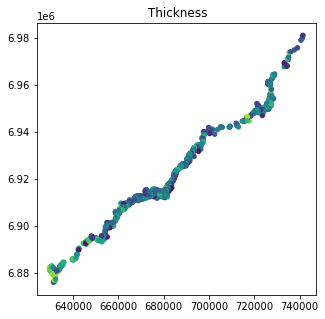

In [8]:
fig,ax = gp.init()
ax.symbol(data,name_color="Thickness")
plt.show()

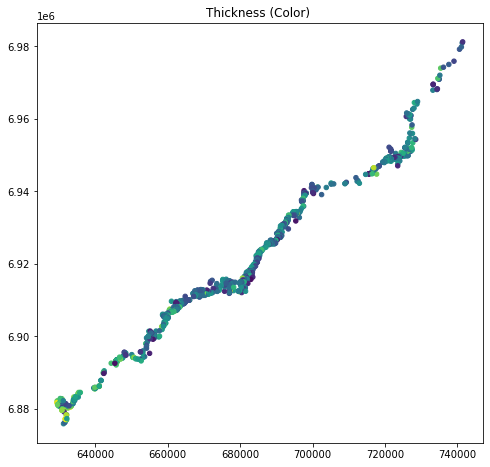

In [9]:
gp.plot(data,name_color="Thickness")

(array([ 24.,  64., 148., 219., 219., 156.,  89.,  60.,  29.,  14.]),
 array([ 0.4 ,  1.95,  3.5 ,  5.05,  6.6 ,  8.15,  9.7 , 11.25, 12.8 ,
        14.35, 15.9 ]),
 <BarContainer object of 10 artists>)

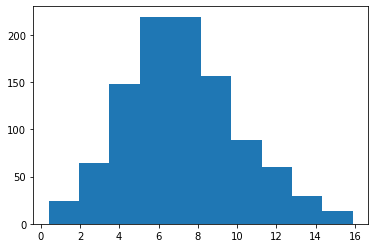

In [10]:
plt.hist(thickness)

In [11]:
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 1022
Number of active samples     = 1007

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Epaisseur - Locator = lower1
Column = 4 - Name = Epaisseur_1 - Locator = upper1
Column = 5 - Name = Thickness - Locator = z1
Column = 6 - Name = Duplicate - Locator = sel

In [12]:
filename = os.path.join(DIRDATA,"Oise_Data.ascii")
data.dumpToNF(filename)

True

## Creation of the grid

### 1) Creation of the polygon

In [13]:
filename = "Oise_Alluvial.csv"

In [14]:
poly = gl.Polygons.createFromCSV(filename, csv, True)

Column Name (1): X
 Column Name (2): Y
 Number of columns = 2
 Data table read (Oise_Alluvial.csv) successfully
 - Number of columns = 2
 - Number of rows    = 1437
 

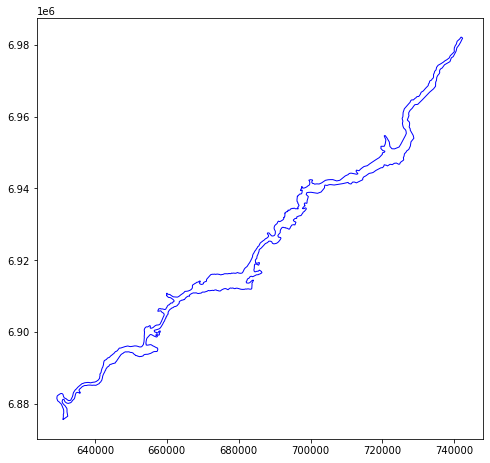

In [15]:
ax = poly.plot()

In [16]:
grid = gl.DbGrid.create(nx = [3300,400],dx = [50.,50.], x0 = [630000.,6865000.],angles=[40,0])

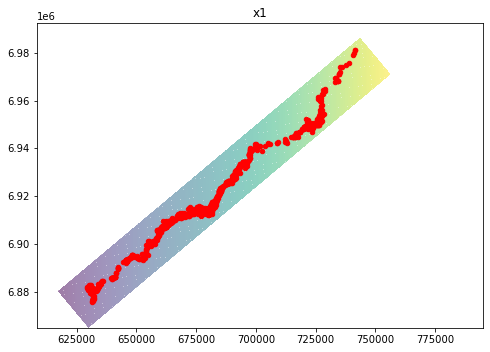

In [17]:
fig, ax = gp.initGeographic()
ax.raster(grid,"x1",alpha=0.3)
ax.symbol(data)

In [18]:
err = gl.db_polygon(grid,poly)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 1320000
Number of active samples     = 138248

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = sel

### 2) Creation of angles

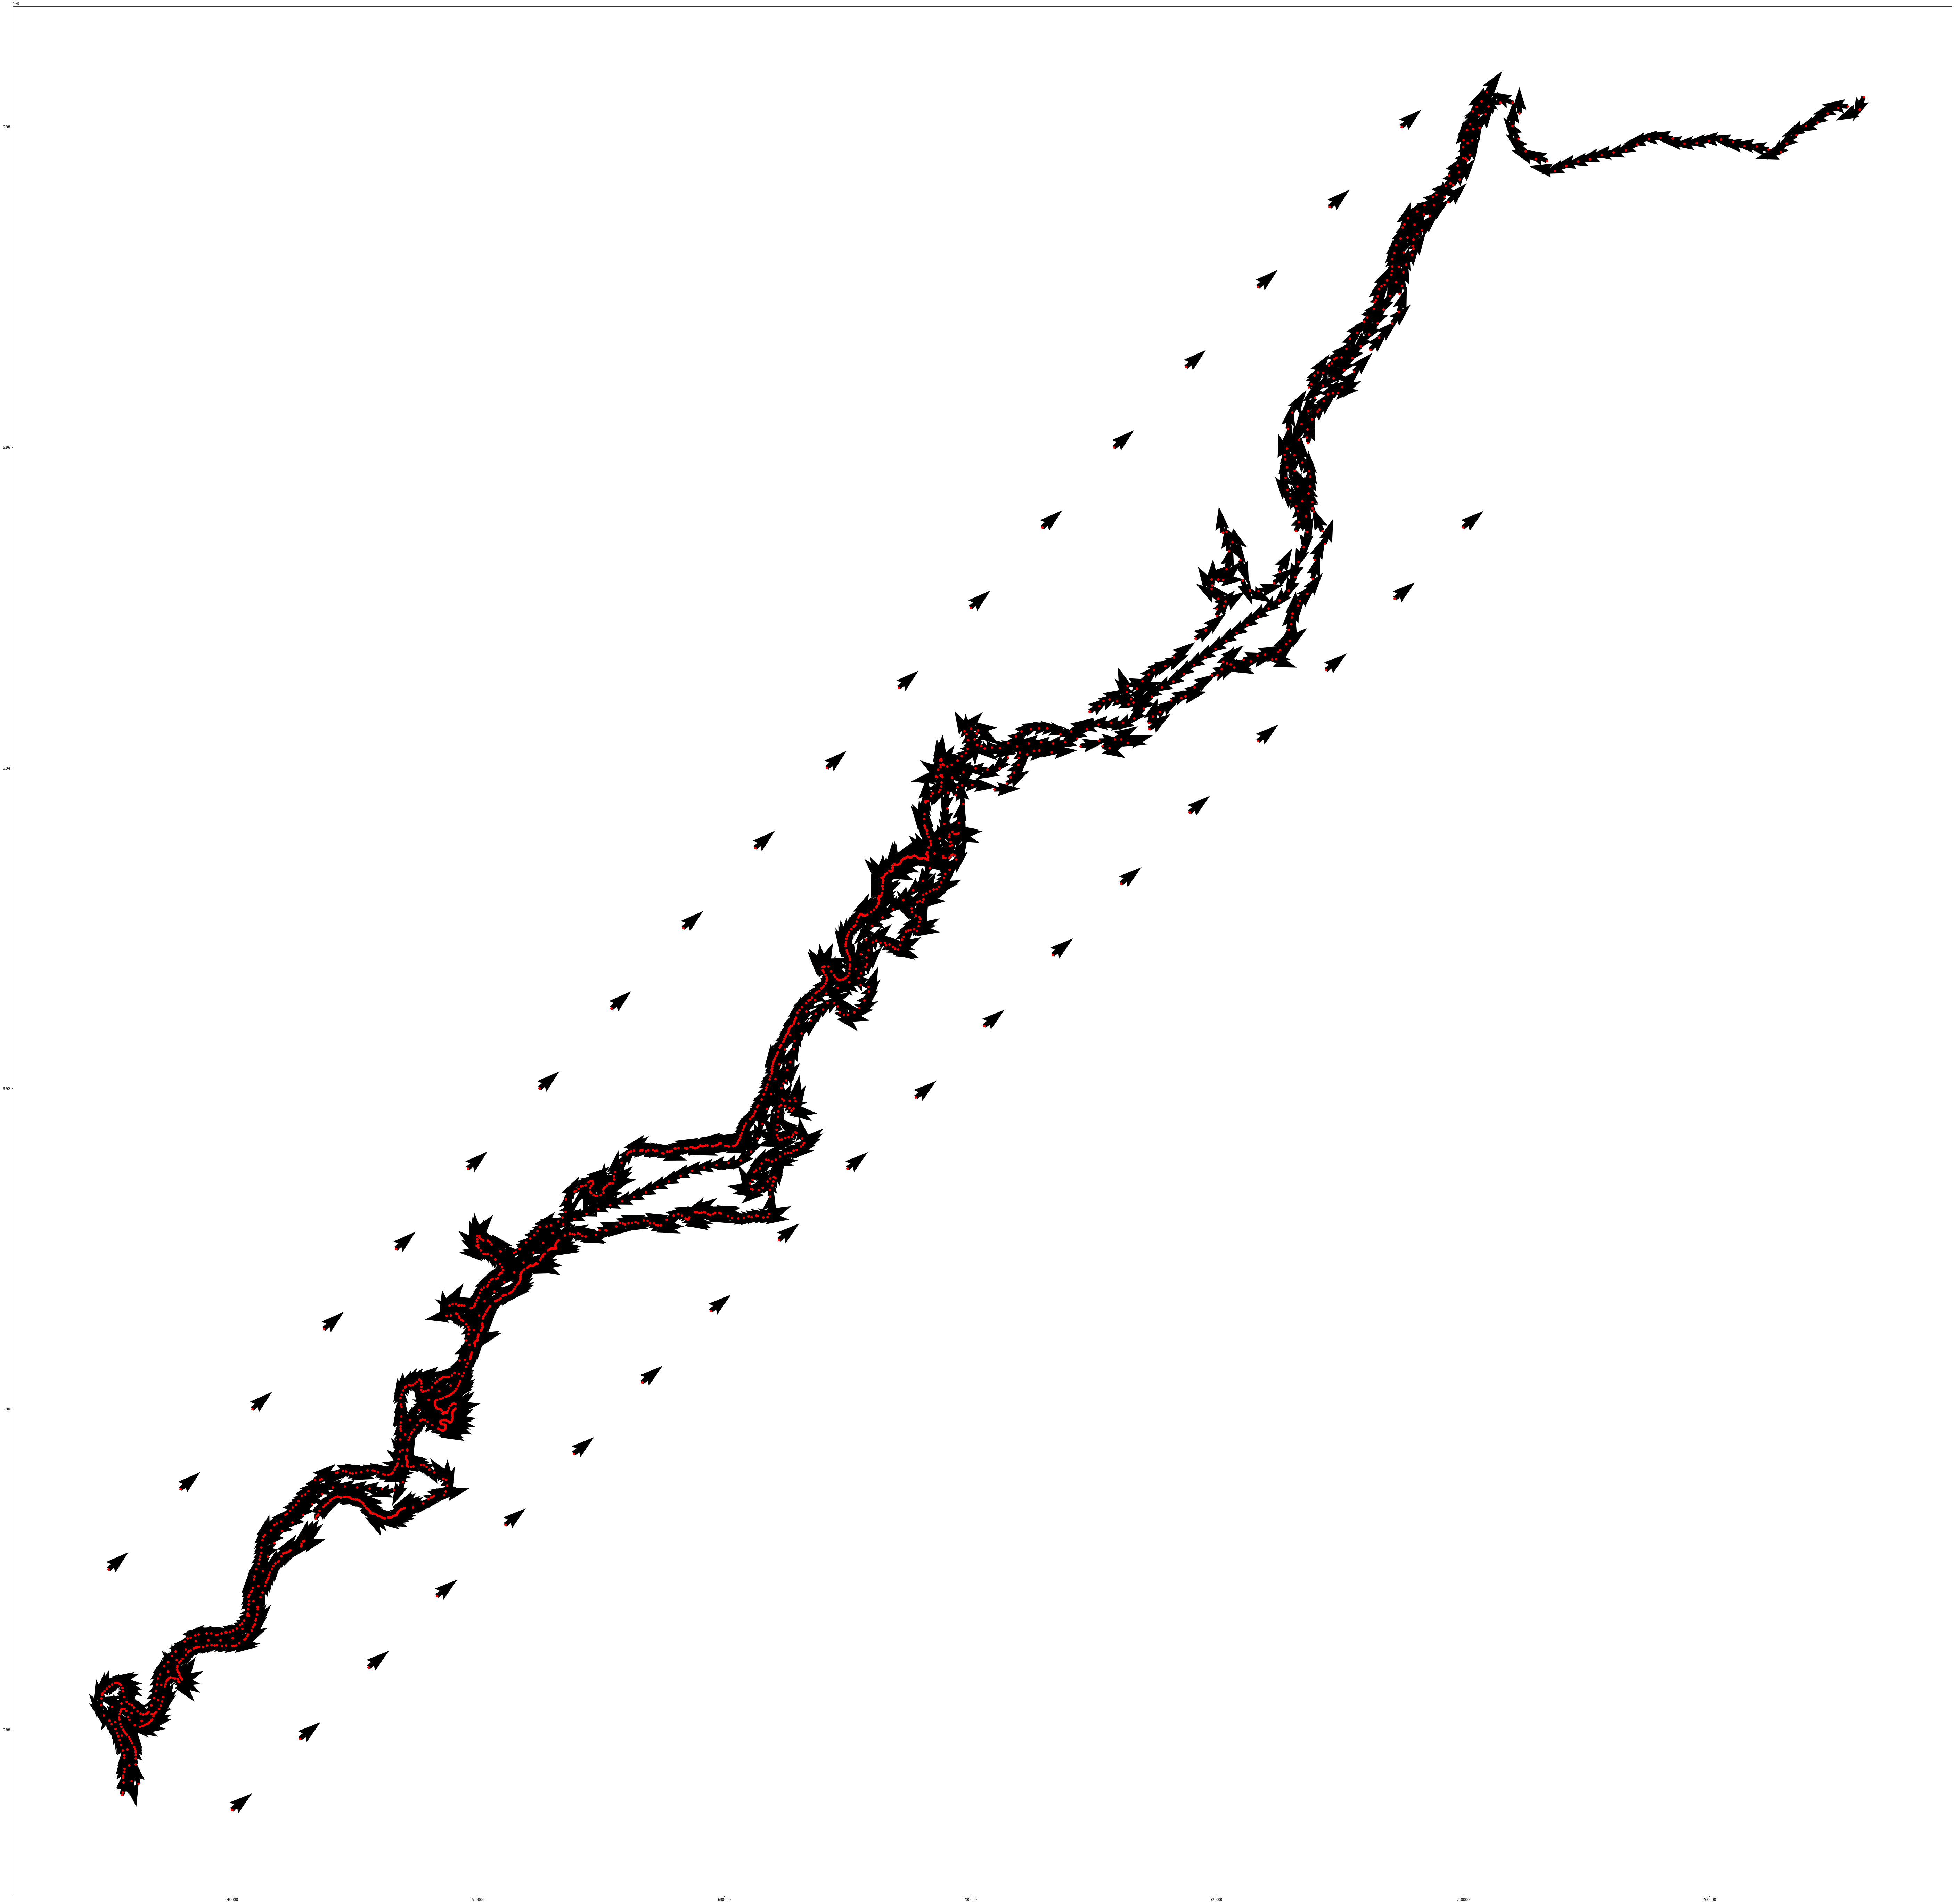

In [19]:
fileCenter = "Oise_Centerline.csv"
fileAlluvial = "Oise_Alluvial.csv"

## Loading Centerline data from file
df1 = pd.read_csv (fileCenter, sep=';')
xc = list(df1['X'])
yc = list(df1['Y'])
x1=xc[1:499]
y1=yc[1:499]

## Loading alluvial plain contours from file & Separate into two polylines 
df = pd.read_csv (fileAlluvial, sep=';')
xp = list(df['X'])
yp = list(df['Y'])
x2=xp[1:xp.index(max(xp))]
x3=xp[len(xp):xp.index(max(xp))+1:-1]
y2=yp[1:xp.index(max(xp))]
y3=yp[len(xp):xp.index(max(xp))+1:-1]

## Adding supplementary control points at the edges
# coordinates of extremes
XA1=640000
YA1=6875000
XB1=740000
YB1=6955000

XA2=630000
YA2=6890000
XB2=735000
YB2=6980000

# Forming two supplementary vectors at the edges
n=19
x4= np.zeros(n)
y4= np.zeros(n)
x5= np.zeros(n)
y5= np.zeros(n)
for i in range(0,len(x4)):
    x4[i]=(XA1+(XB1-XA1)/(n-1)*i)
    y4[i]=(YA1+(YB1-YA1)/(n-1)*i)
    x5[i]=(XA2+(XB2-XA2)/(n-1)*i)
    y5[i]=(YA2+(YB2-YA2)/(n-1)*i)

# Methode du gradient 
#  https://stackoverflow.com/questions/28269379/curve-curvature-in-numpy
dx_dt1 = np.gradient(x1)
dy_dt1 = np.gradient(y1)
velocity = np.array([ [dx_dt1[i], dy_dt1[i]] for i in range(dx_dt1.size)])
ds_dt1 = np.sqrt(dx_dt1 * dx_dt1 + dy_dt1 * dy_dt1)
tangent1 = np.array([1/ds_dt1] * 2).transpose() * velocity

dx_dt2 = np.gradient(x2)
dy_dt2 = np.gradient(y2)
velocity2 = np.array([ [dx_dt2[i], dy_dt2[i]] for i in range(dx_dt2.size)])
ds_dt2 = np.sqrt(dx_dt2 * dx_dt2 + dy_dt2 * dy_dt2)
tangent2 = np.array([1/ds_dt2] * 2).transpose() * velocity2

dx_dt3 = np.gradient(x3)
dy_dt3 = np.gradient(y3)
velocity3 = np.array([ [dx_dt3[i], dy_dt3[i]] for i in range(dx_dt3.size)])
ds_dt3 = np.sqrt(dx_dt3 * dx_dt3 + dy_dt3 * dy_dt3)
tangent3 = np.array([1/ds_dt3] * 2).transpose() * velocity3

dx_dt4 = np.gradient(x4)
dy_dt4 = np.gradient(y4)
velocity4 = np.array([ [dx_dt4[i], dy_dt4[i]] for i in range(dx_dt4.size)])
ds_dt4 = np.sqrt(dx_dt4 * dx_dt4 + dy_dt4 * dy_dt4)
tangent4 = np.array([1/ds_dt4] * 2).transpose() * velocity4

dx_dt5 = np.gradient(x5)
dy_dt5 = np.gradient(y5)
velocity5 = np.array([ [dx_dt5[i], dy_dt5[i]] for i in range(dx_dt5.size)])
ds_dt5 = np.sqrt(dx_dt5 * dx_dt5 + dy_dt5 * dy_dt5)
tangent5 = np.array([1/ds_dt5] * 2).transpose() * velocity5
    
tangent=np.concatenate((tangent1,tangent2,tangent3,tangent4,tangent5),axis=0) 

x0=np.concatenate((x1,x2,x3,x4,x5),axis=0) 
y0=np.concatenate((y1,y2,y3,y4,y5),axis=0) 
u0 = tangent[:, 0]
v0 = tangent[:, 1]


# Visualize vectors
fig, ax = plt.subplots(figsize = (100,100))
plt.figure(1)
plt.quiver(x0,y0,u0,v0)

plt.plot(x0,y0,'ro')
#plt.savefig('vectors.pdf') 


In [20]:
df = pd.read_csv (fileAlluvial, sep=';')
df

,X,Y
0,631065,6875650
1,631083,6875930
2,631145,6876080
3,631200,6876700
4,631169,6877010
...,...,...
1432,632202,6878600
1433,632195,6878410
1434,632206,6878200
1435,632205,6877830


In [21]:
# Interpolating the vectors into vector map -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

xx = np.linspace(630000, 742000, 2240)
yy = np.linspace(6875000, 6982200, 2144)
xx, yy = np.meshgrid(xx, yy)

u0.shape=(np.size(u0),)
np.shape(u0)
v0.shape=(np.size(v0),)
np.shape(v0)

points = np.transpose(np.vstack((x0, y0)))
u_interp = interpolate.griddata(points, u0, (xx, yy), method='linear')
v_interp = interpolate.griddata(points, v0, (xx, yy), method='linear')

xx1 = np.concatenate(xx)
yy1 = np.concatenate(yy)
u_interp1 = np.concatenate(u_interp)
v_interp1 = np.concatenate(v_interp)


In [22]:
#Créer une Db point avec xx, yy, u_interp, v_interp
dbv = gl.Db()
dbv.addColumns(xx1,"xx",gl.ELoc.X, 0)
dbv.addColumns(yy1,"yy",gl.ELoc.X, 1)
dbv.addColumns(u_interp1,"u_interp",gl.ELoc.Z, 0)
dbv.addColumns(v_interp1,"v_interp",gl.ELoc.Z, 1)
dbv.display()
grid.setLocator("Pol*")
grid.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 4802560

Variables
---------
Column = 0 - Name = xx - Locator = x1
Column = 1 - Name = yy - Locator = x2
Column = 2 - Name = u_interp - Locator = z1
Column = 3 - Name = v_interp - Locator = z2
 
Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 1320000

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matri

In [23]:
#Tester la valeur retournée par migrate :
grid.deleteColumn("Migr*")
grid.display()
gl.migrate(dbv, grid, "u_interp")
gl.migrate(dbv, grid, "v_interp")
grid.setLocator("Migrate*", gl.ELoc.Z)
#grid.display(sf)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 1320000

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
 

In [24]:
grid.useSel = False
grid.setLocator("Polygon")
uid_selection=grid.addSelectionByLimit("*u_interp*", gl.Limits([-10], [10]), "vec_define")

In [25]:
xplt = grid.getColumnByLocator(gl.ELoc.X,0,useSel=True)
yplt = grid.getColumnByLocator(gl.ELoc.X,1,useSel=True)
uplt = grid.getColumnByLocator(gl.ELoc.Z,0,useSel=True)
vplt = grid.getColumnByLocator(gl.ELoc.Z,1,useSel=True)

In [26]:
plt.figure(figsize=(200,200))
plt.quiver(xplt, yplt, uplt, vplt, headwidth =3, width= 0.0005, scale = 200, headlength= 5,  label='Field vectors')
plt.plot(x0,y0,'ro',markersize=10, label='Alluvial plain')
#plt.savefig('vectorsfield.pdf')

In [27]:
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 1320000
Number of active samples     = 927470

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
Column = 4 - Name = Migrate.u_interp - Locator = z1
Column = 5 - Name = Migrate.v_interp - Locator = z2
Column = 6 - N

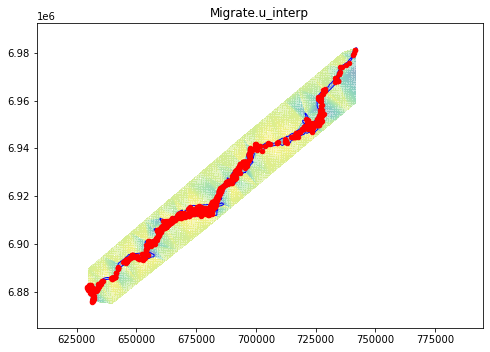

In [28]:
fig,ax = gp.initGeographic()
ax.raster(grid,"*.u_interp",alpha=0.3,usesel=False)
ax.polygon(poly)
ax.symbol(data)

In [29]:
filename = os.path.join(DIRDATA,"Oise_GridVector.ascii")
grid.dumpToNF(filename)

True

# Pour Diana

In [30]:
fileSave = os.path.join(DIRDATA,"Oise_GridVector.ascii")
grid = gl.DbGrid.createFromNF(fileSave)

In [31]:
u = grid["Migrate.u_interp"]
v = grid["Migrate.v_interp"]
res = 0. * u

for i in range(u.shape[0]):
    res[i] = gl.GH.rotationGetAngles((u[i], v[i]))[0]
    
grid.deleteColumn("angles*")
grid["angles1"]= res
grid.setLocator("angles*",gl.ELoc.NOSTAT)

### 3) Creation of a selection (polygon + borders by morphological dilation)

In [32]:
grid.setLocator("Poly*", gl.ELoc.SEL)

In [33]:
vmin = 0.5
vmax = 1.5
nxy = grid.getNXs()
image2 = gl.BImage(nxy)

tab = grid.getColumn("Polygon",useSel=False)
image = gl.morpho_double2image(nxy,tab,vmin,vmax)
localVD = gl.VectorDouble(len(tab))
gl.morpho_dilation(0, [3,3], image, image2)
for i in range(10):
    gl.morpho_dilation(0, [1,1], image, image2)
    gl.morpho_dilation(0, [1,1], image2, image)
#gl.morpho_dilation(0, [1,1], image, image2)

gl.morpho_image2double(image2, 0, 1., 0., localVD)

In [34]:
grid["res"]=localVD.getVector()

In [35]:
grid.setLocator("res",gl.ELoc.SEL)

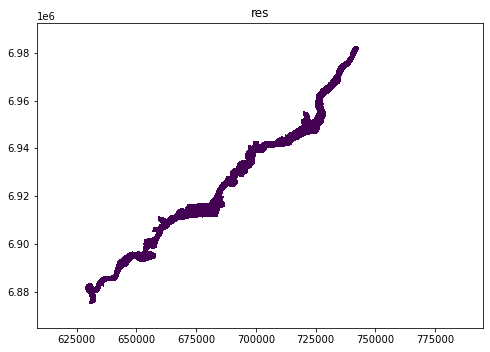

In [36]:
fig,ax = gp.initGeographic()
ax.raster(grid,"res")

### 4) Save the result

In [37]:
fileFinal = os.path.join(DIRDATA,"Oise_GridVectorFinal.ascii")
grid.dumpToNF(fileFinal)

True